# AEON

В этой лекции мы более подробно поработаем с библиотекой aeon

Aeon — это совместимый с scikit-learn набор инструментов для работы с временными рядами (TSML). Он организован в 
модули для различных задач обучения: классификация, регрессия, кластеризация, прогнозирование, обнаружение аномалий, сегментация и поиск по сходству. 

Aeon - хорошо документированная библиотека, имеет большое количество блокнотов, доступных в [документации](https://www.aeon-toolkit.org/en/stable/). Эта работа составлена на основе блокнотов, представленных в руководстве. 

Будем использовать для примера наборы данных ЭЭГ. Все используемые типы данных представляют собой трехмерные массивы (3D numpy arrays).

# Структуры данных и наборы данных 

*aeon* предполагает, что один временной ряд представляет собой двумерный массив формы `(n_channels, n_timepoints)`. 

Классификаторы и регрессоры принимают входные коллекции временных рядов (и наследуют от BaseCollectionEstimator). 

Если все серии имеют одинаковую длину, лучше всего работает с трехмерной фигурой `(n_cases, n_channels, n_timepoints)`. 

Серии разной длины хранятся в списках 2D numpy, но примеры, которые мы собираемся использовать, будут иметь одинаковую длину. 

В этом уроке в качестве рабочего примера будут использоваться данные ЭЭГ. 

Классификационный набор данных состоит из показаний ЭЭГ, снятых у испытуемого в состоянии покоя или при выполнении заданной задачи (поднятие рук). Полную информацию об этих данных можно найти в [блокноте](https://github.com/aeon-toolkit/aeon-neuro/blob/main/examples/data_loading.ipynb). 

*aeon* поставляется с некоторыми стандартными наборами данных UCR и UEA, и их все можно загрузить непосредственно с [timeseriesclassification.com](https://timeseriesclassification.com).

# Содержание

* [Меры расстояний](#distance-tsc)
* [Distance-based univariate Time Series Classification (TSC)](#classification) 
* [Distance-based  Time Series Extrinsic Regression](#regres)
* [Подходы, основанные на свертках](#conv)
* [Feature based classification and regression](#feature)
* [Deep Learning подходы](#deep)
* [Упражнения](#tasks)

## Меры расстояний  <a id="distance-tsc"></a> 
Подходы, основанные на сходстве, были одним из первых предложений по классификации и регрессии временных рядов. Более того, эти типы методов также распространены для выполнения других задач временных рядов, таких как кластеризация или обнаружение аномалий и других. 

В первой части этой тетради представлены расстояния, реализованные в эоне, начиная с самого простого — евклидова расстояния. Затем он представляет расстояние динамического искажения времени (DTW), его варианты, такие как Amerced DTW (ADTW) или Shape DTW (ShapeDTW), а также некоторые другие альтернативные расстояния, такие как Move-Split-Merge (MSM). 

Во второй части этого блокнота мы демонстрируем использование этих расстояний в сочетании с классификатором KNearestNeighbours из scikit-learn, а также более подходящую реализацию KNearestNeighbours для временных рядов, включенных в aeon. Аналогичным образом также представлены подходы к работе с наборами данных TSER с использованием дистанционных подходов. 

Документация aeon содержит записные книжки по   [растоянию](https://www.aeon-toolkit.org/en/stable/examples/distances/distances.html) and [классификации на основе дистанции](https://www.aeon-toolkit.org/en/stable/examples/classification/distance_based.html) и искользования `aeon` расстояних с [`scikit-learn`](https://www.aeon-toolkit.org/en/stable/examples/distances/sklearn_distances.html).

In [ ]:
%pip install aeon[all_extras]
%mkdir -p dataset


Чтобы использовать следующие команды, нужно убедиться, что wget установлен в вашей системе
Скачать нужную версию wget можно с официального сайта  https://eternallybored.org/misc/wget/
После скачивания - положить wget.exe сюда C:\Windows\System32

Проблема windows еще и в том, что в powershell установлены allias  для iwr, curl, wget. При попытке к запустить эти команды будет запускаться виндовская Invoke-WebRequest .
Поэтому или запускать с указанием расширения (например, wget.exe), или измненить алиас. Сделать это можно следующим образом.

1. Запускаем powershell или cmd.

2. Смотрим, что привязано к комманде wget:
Get-Alias -Name wget

3. Если видите ответ типа "Alias           wget -> Invoke-WebRequest", то удаляем алиас:
Remove-Item -Path Alias:\wget

4. Проверяем командой 2. Должно выдать ошибку.

5. Устанавливаем новый алиас
New-Alias wget wget.exe

Все, спокойно пользуемся привычным wget - ом.


In [ ]:
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TRAIN.ts -P dataset/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TEST.ts -P dataset/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TRAIN.ts -P dataset/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TEST.ts -P dataset/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TRAIN.ts -P dataset/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSER_TEST.ts -P dataset/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TRAIN.ts -P dataset/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TEST.ts -P dataset/

File 'dataset/KDD_MTSC_TRAIN.ts' already there; not retrieving.

--2026-01-09 20:22:08--  https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TEST.ts
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366653 (358K) [text/plain]
Saving to: 'dataset/KDD_MTSC_TEST.ts'

     0K .......... .......... .......... .......... .......... 13%  108M 0s
    50K .......... .......... .......... .......... .......... 27%  305M 0s
   100K .......... .......... .......... .......... .......... 41%  340M 0s
   150K .......... .......... .......... .......... .......... 55%  346M 0s
   200K .......... .......... .......... .......... .......... 69%  326M 0s
   250K .......... .......... .......... .......... .......... 83%  311M 0s
   300K .....

In [13]:
# это опционально, если хотите видеть все ворнинги - не запускайте эту ячейку

import warnings

warnings.filterwarnings("ignore")

In [29]:
from aeon.datasets import load_from_ts_file

# Загрузите одномерный набор данных TSC как двумерный массив NumPy

X_train_utsc, y_train_utsc = load_from_ts_file("./dataset/KDD_UTSC_TRAIN.ts", return_type="numpy2D")
X_test_utsc, y_test_utsc = load_from_ts_file("./dataset/KDD_UTSC_TEST.ts", return_type="numpy2D")

print("Single channel EEG TSC problem train shape:", X_train_utsc.shape)
print("Single channel EEG TSC problem test shape:", X_test_utsc.shape)

Single channel EEG TSC problem train shape: (40, 100)
Single channel EEG TSC problem test shape: (40, 100)


In [34]:
# Загрузите многомерный набор данных в виде трехмерного массива numpy

X_train_mtsc, y_train_mtsc = load_from_ts_file("./dataset/KDD_MTSC_TRAIN.ts")
X_test_mtsc, y_test_mtsc = load_from_ts_file("./dataset/KDD_MTSC_TEST.ts")

print("Four channel EEG TSC problem train shape:", X_train_mtsc.shape)
print("Four channel EEG TSC problem test shape:", X_test_mtsc.shape)

Four channel EEG TSC problem train shape: (40, 4, 100)
Four channel EEG TSC problem test shape: (40, 4, 100)


In [31]:
# Загрузите одномерный набор данных TSER как двумерный массив numpy
X_train_utser, y_train_utser = load_from_ts_file("./dataset/KDD_UTSER_TRAIN.ts", return_type="numpy2D")
X_test_utser, y_test_utser = load_from_ts_file("./dataset/KDD_UTSER_TEST.ts", return_type="numpy2D")

print("Single channel EEG TSER problem train shape:", X_train_utsc.shape)
print("Single channel EEG TSER problem test shape:", X_test_utsc.shape)

Single channel EEG TSER problem train shape: (40, 100)
Single channel EEG TSER problem test shape: (40, 100)


In [33]:
# Загрузите многомерный набор данных TSER в виде трехмерного массива numpy
X_train_mtser, y_train_mtser = load_from_ts_file("./dataset/KDD_MTSER_TRAIN.ts")
X_test_mtser, y_test_mtser = load_from_ts_file("./dataset/KDD_MTSER_TEST.ts")

print("Four channel EEG TSER problem train shape:", X_train_mtser.shape)
print("Four channel EEG TSER problem test shape:", X_test_mtser.shape)

Four channel EEG TSER problem train shape: (72, 4, 100)
Four channel EEG TSER problem test shape: (72, 4, 100)


Для наших примеров измерения расстояния давайте определим два разных случайных одномерных временных ряда (a и b) длиной m=10 и построим их график.

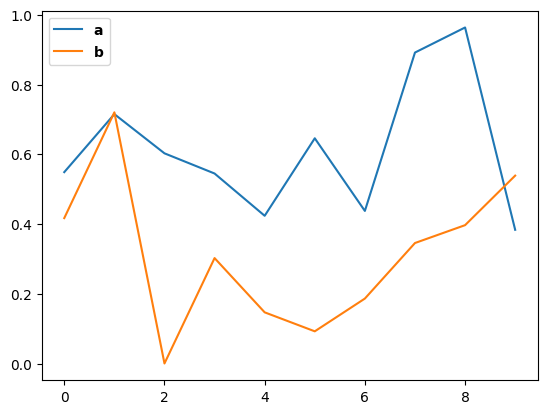

In [24]:
from aeon.testing.data_generation import make_example_1d_numpy
import seaborn as sns
import matplotlib.pyplot as plt

a = make_example_1d_numpy(n_timepoints=10, random_state=0)
b = make_example_1d_numpy(n_timepoints=10, random_state=1)

sns.lineplot(data=a, label=r"$\mathbf{a}$")
sns.lineplot(data=b, label=r"$\mathbf{b}$")

plt.show()

#### Euclidean Distance (direct alignment)  
 

In [27]:
# Считаем по формуле вручную

import numpy as np

ED = np.sqrt(np.sum(np.power(a-b,2)))

print(f"The Euclidean distance between a and b is {ED}")

The Euclidean distance between a and b is 1.236743116180222


In [28]:
# Используем aeon

from aeon.distances import euclidean_distance

print(
    f"The Euclidean distance computed in aeon between a and b is",
    f"{euclidean_distance(a, b)}"
)

The Euclidean distance computed in aeon between a and b is 1.236743116180222


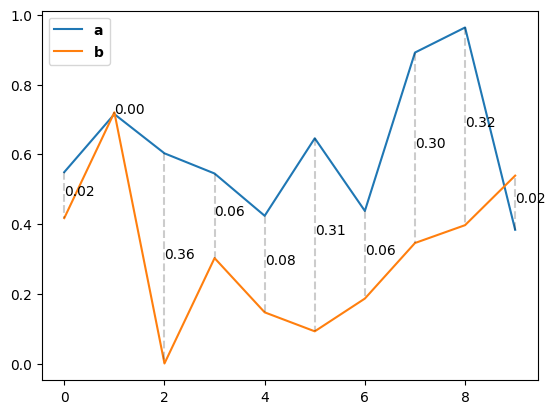

In [ ]:
# Постройте расстояния временных рядов поточечно, следуя по пути.
def plot_time_series_distances(a, b, cost_matrix, path):
    sns.lineplot(data=a, label=r"$\mathbf{a}$")
    sns.lineplot(data=b, label=r"$\mathbf{b}$")

    # соединить точки на пути
    for i in range(len(path)):
        plt.plot(
            [path[i][0], path[i][1]],
            [a[path[i][0]], b[path[i][1]]],
            'k--',
            alpha=0.2
        )
        plt.text(
            (path[i][0]+path[i][1])/2,
            (a[path[i][0]]+b[path[i][1]])/2,
            f"{cost_matrix[path[i][0], path[i][1]]:.2f}"
        )

    return plt

# Вычислите квадрат матрицы расстояний между a и b.
def squared_pointwise_distance(a, b):
    n_timesteps = len(a)
    distances_matrix = np.zeros((n_timesteps, n_timesteps))

    for i in range(n_timesteps):
        for j in range(n_timesteps):
            distances_matrix[i, j] = (a[i]-b[j])**2

    return distances_matrix


cost_matrix = squared_pointwise_distance(a,b)
path = [(i, i) for i in range(len(a))]

ax = plot_time_series_distances(a, b, cost_matrix, path)

plt.show()

Евклидово расстояние также можно определить как квадратный корень из суммы квадратов разностей значений на диагонали всех возможных расстояний между элементами в обоих временных рядах. 

Прежде всего, мы вычисляем матрицу расстояний, которая содержит расстояния для всех элементов обоих временных рядов:

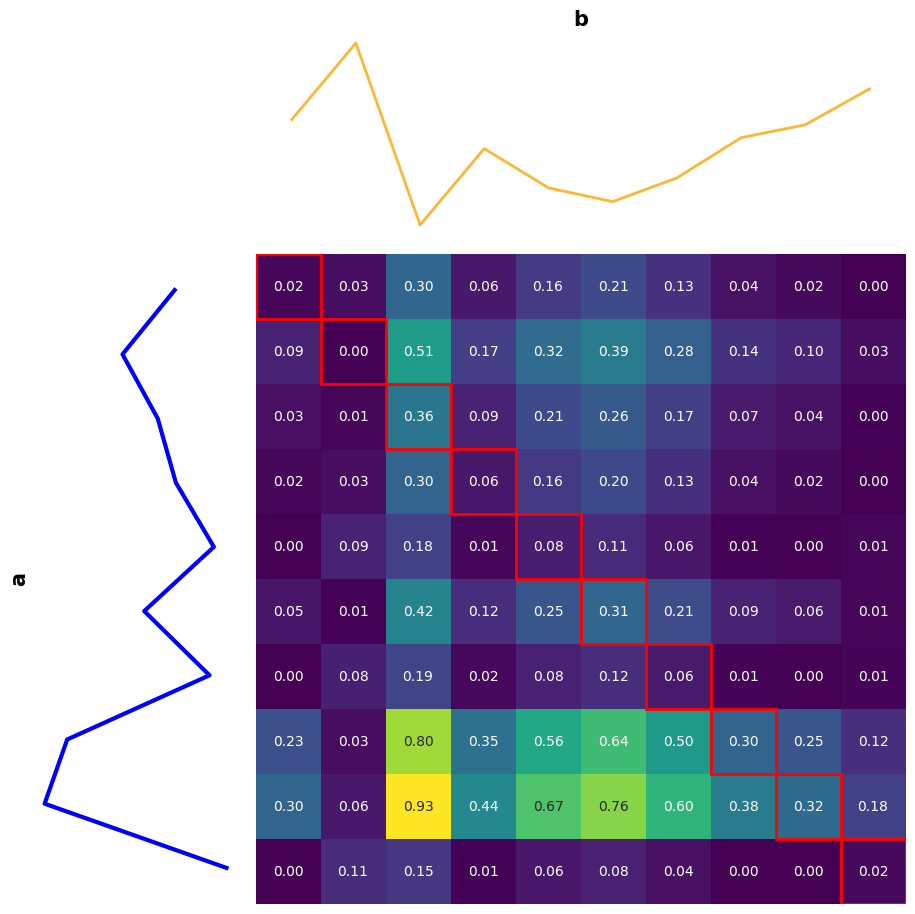

In [30]:
from aeon.visualisation.distances._pairwise_distance_matrix import plot_pairwise_distance_matrix

# Compute the squared pointwise distances between a and b
distance_matrix = squared_pointwise_distance(a, b)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(distance_matrix, a, b, path)
plt.show()

#### Гибкое расстояние: динамическое искажение времени (DTW) 
 DTW допускает выравнивание по временным шагам, т. е. не обязательно выравнивать временные шаги, а только первый и последний временные шаги. 

В этом первом примере мы позволяем DTW иметь последовательные выравнивания, продвигающиеся не более чем на один временной шаг в каждой серии.

In [31]:
from aeon.distances import dtw_distance

print(
    f"The DTW distance computed in aeon between a and b is",
    f"{dtw_distance(a, b, window=0.1)}"
)

The DTW distance computed in aeon between a and b is 1.1985498275436108


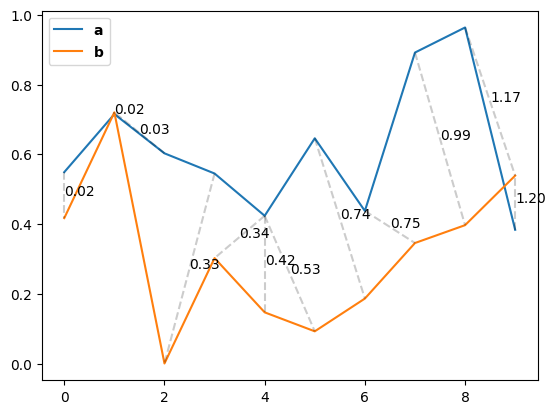

In [32]:
from aeon.distances import dtw_alignment_path, dtw_cost_matrix

path, _ = dtw_alignment_path(a, b, window=0.1)
cost_matrix = dtw_cost_matrix(a, b, window=0.1)

sns.lineplot(data=a, label=r"$\mathbf{a}$")
sns.lineplot(data=b, label=r"$\mathbf{b}$")

# join the points in the path
for i in range(len(path)):
    plt.plot([path[i][0], path[i][1]], [a[path[i][0]], b[path[i][1]]], 'k--', alpha=0.2)
    plt.text(
        (path[i][0]+path[i][1])/2,
        (a[path[i][0]]+b[path[i][1]])/2,
        f"{cost_matrix[path[i][0], path[i][1]]:.2f}"
    )

plt.show()

Сравните графики DTW и декартового расстояния. Какие выводы?

Как можно заметить, теперь расстояния не вычисляются для одних и тех же моментов времени. Они 
рассчитываются с учетом коллиндантных моментов времени. 

В этом случае расстояние — это путь с минимальной стоимостью, который удовлетворяет вышеупомянутым условиям. 

Ограничения: 

(Обратите внимание, что для удобства чтения пути начальная позиция должна быть последней, 
в данном случае (9,9), и мы перемещаем ближайшую точку времени. Например, из (9,9) мы 
может перейти в: A) (8, 9) со стоимостью 1,32, B) (8, 8) со стоимостью 1,32 или C) (9, 8) 
со стоимостью 1,17. Последнее - правильный выбор.)

DTW distance between a and b is 1.1985498275436108.


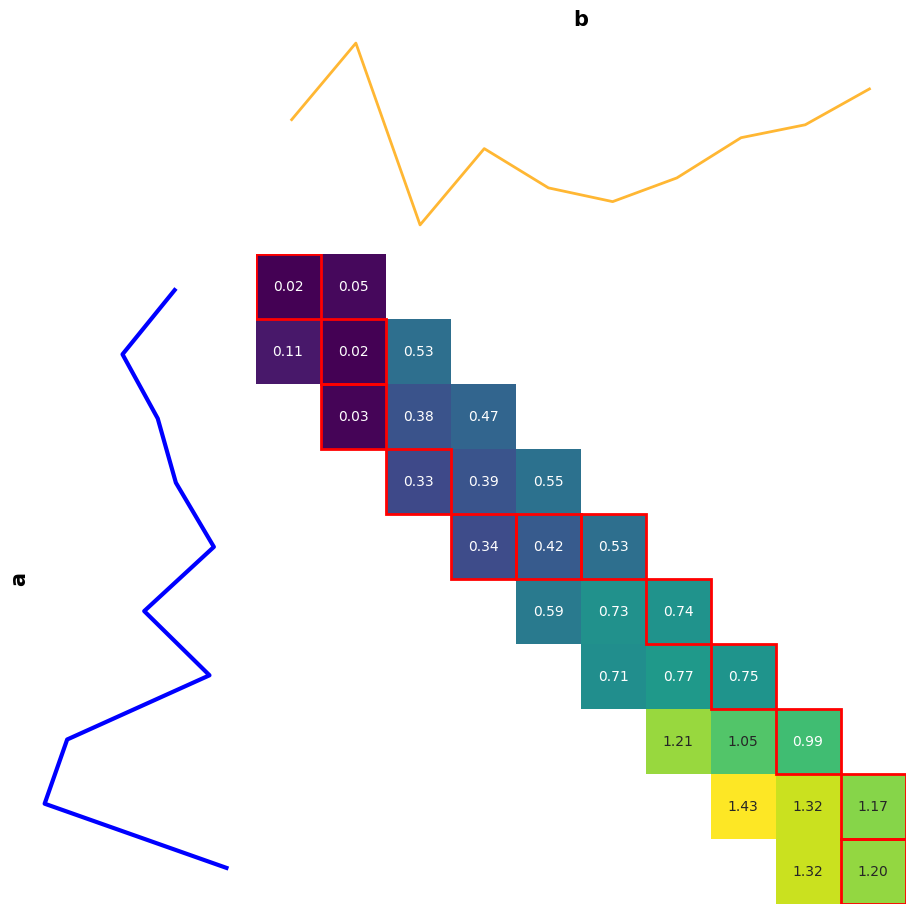

In [33]:
path, dtw_dist = dtw_alignment_path(a, b, window=0.1)
print(f"DTW distance between a and b is {dtw_dist}.")
# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=0.1)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(cost_matrix, a, b, path)
plt.show()

Важно знать, что  DTW может быть более терпимой и предоставлять более широкие возможности выравнивания временных рядов. Чтобы контролировать такое поведение, мы определяем еще одно ограничение: размер окна. 

Это ограничение окон позволяет избежать выравнивания точек, разделенных более чем определенным процентом от длины временного ряда. Другими словами, если ограничение окна равно $w$, выравнивание $i$-й точки можно выполнить только с точками из интервала 

$[i - \lfloor w*m \rfloor, i + \lfloor w*m \rfloor]$. 

В предыдущем сценарии не использовался размер окна (эквивалент ограничения окна $w=1$.). 

Теперь, если мы уменьшим длину окна до $w=0,5$, мы увидим, что путь изменился:

DTW distance with w=0.5 between a and b is 0.8566491595090396.


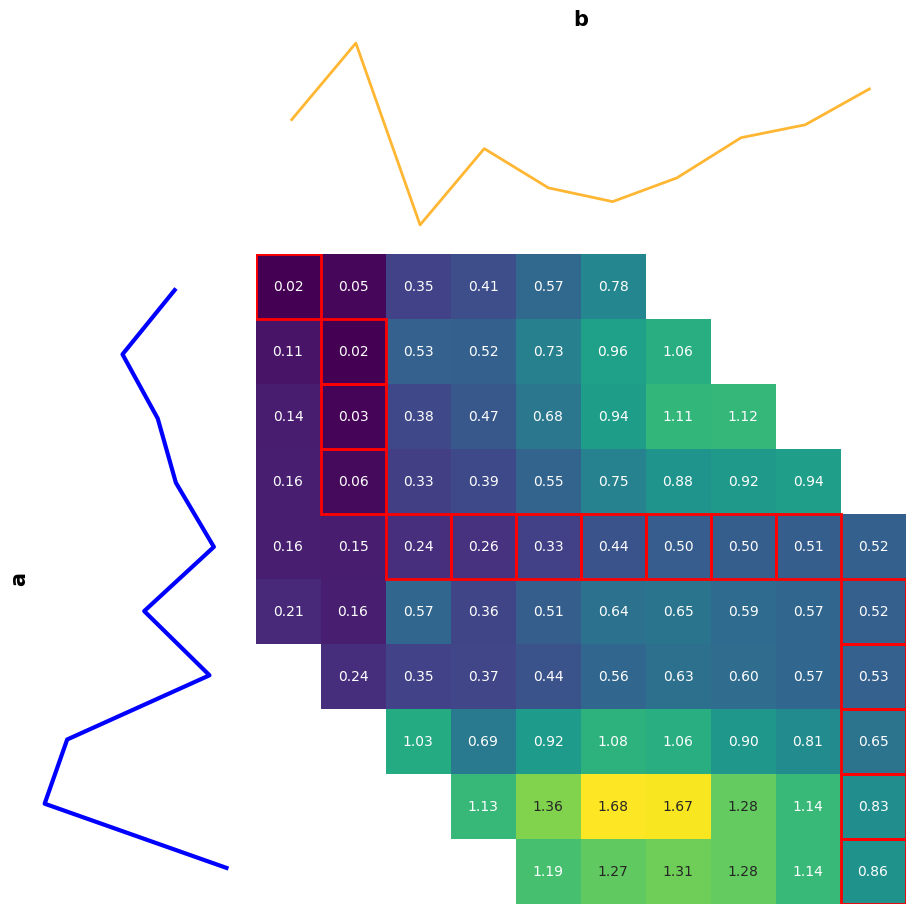

In [34]:
w = 0.5
path, dtw_dist = dtw_alignment_path(a, b, window=w)
print(f"DTW distance with {w=} between a and b is {dtw_dist}.")

# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=w)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(cost_matrix, a, b, path)
plt.show()

Посмотрим, что будет при ограничении окна в 20%.

DTW distance with w=0.2 between a and b is 0.9199809594402144.


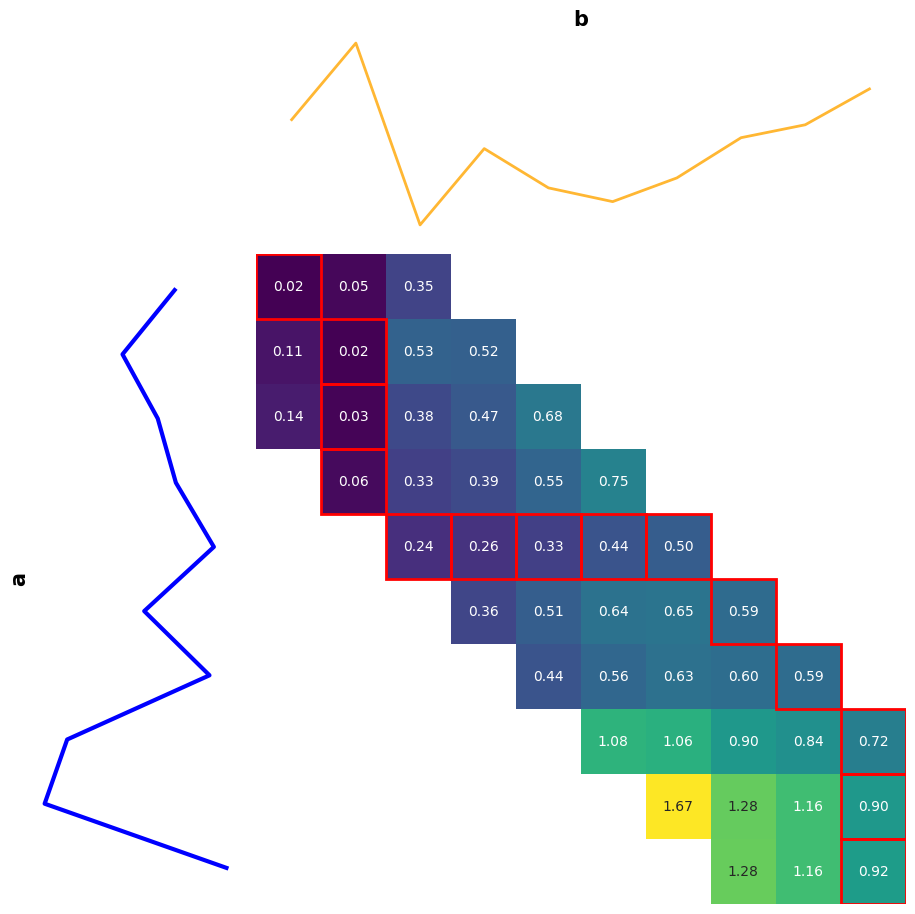

In [35]:
w = 0.2
path, dtw_dist = dtw_alignment_path(a, b, window=w)
print(f"DTW distance with {w=} between a and b is {dtw_dist}.")

# Compute the DTW cost matrix between a and b
cost_matrix = dtw_cost_matrix(a, b, window=w)

# Draw the heatmap
ax = plot_pairwise_distance_matrix(cost_matrix, a, b, path)
plt.show()

Можем посмотреть, какие варианты DTW реализованы в aeon. И сравнить получаемые расстояния.

In [36]:
from aeon.distances._distance import DISTANCES

# These are the DTW variants available in aeon for time series:
dtw_variants = [d["name"] for d in DISTANCES if 'dtw' in d["name"]]
print(f"DTW variants available in aeon: {dtw_variants}")

DTW variants available in aeon: ['dtw', 'dtw_gi', 'ddtw', 'wdtw', 'wddtw', 'adtw', 'shape_dtw', 'soft_dtw']


In [37]:
from aeon.distances import get_distance_function

for variant in dtw_variants:
    distance_function = get_distance_function(variant)
    distance = distance_function(a, b, window=0.2)
    print(f"{variant} distance between a and b is {distance}")

dtw distance between a and b is 0.9199809594402144
dtw_gi distance between a and b is 0.9199809594402144
ddtw distance between a and b is 0.31002884948727205
wdtw distance between a and b is 0.41867594005282865
wddtw distance between a and b is 0.13960840776560768
adtw distance between a and b is 1.5295335354191664
shape_dtw distance between a and b is 1.5295335354191666
soft_dtw distance between a and b is 11.074455734012375


Посмотрим, какие вообще метрики расстояния раелизованы в aeon и сравним их.

In [42]:
for dist in DISTANCES:
    try:
        print(f"{dist['name']} distance between a and b is {dist['distance'](a, b)}")
    except TypeError as err:
        print(f"{dist['name']} - {err}")

euclidean distance between a and b is 1.236743116180222
squared distance between a and b is 1.5295335354191664
manhattan distance between a and b is 3.3323904398054873
minkowski distance between a and b is 1.2367431161802223
dtw distance between a and b is 0.6574923997015053
dtw_gi distance between a and b is 0.6574923997015053
ddtw distance between a and b is 0.31002884948727205
wdtw distance between a and b is 0.3235461427240929
wddtw distance between a and b is 0.13960840776560768
lcss distance between a and b is 0.0
erp distance between a and b is 3.021868759085019
edr distance between a and b is 0.8
twe distance between a and b is 6.5094056644333955
msm distance between a and b is 3.3323904398054873
adtw distance between a and b is 1.5295335354191664
shape_dtw distance between a and b is 1.5295335354191666
soft_dtw distance between a and b is 11.740090024872542
sbd distance between a and b is 0.3633143104636234
shift_scale distance between a and b is 0.5568073651552791
dft_sfa - n

# Distance-based  Time Series Classification (TSC) <a id="classification"></a> 

## Univariate Time Series 

Одним из первых способов классификации набора временных рядов является использование k-ближайшего 
подход соседей (kNN) в сочетании с соответствующей мерой расстояния временного ряда. 

Самый простой способ — использовать подход kNN «scikit-learn» в сочетании с определением расстояний. 
реализовано в `aeon`. Есть два разных способа: 

1. Передайте функцию расстояния как вызываемую для параметра «метрика» в конструкторе. 

или 

2. Установите в конструкторе для метрики значение «предварительно вычисленное» и передайте попарное расстояние. 
матрица для «подгонки» и «предсказания». 



В этом примере мы загружаем набор данных о прицеле, используя двумерный массив numpy, который имеет два размера (n_cases, n_timepoints), учитывая, что это принятый формат `scikit-learn`. 
Несмотря на то, что `aeon` позволяет использовать 2D-массивы, обычно предпочитает 3D-массивы в форма (n_cases, n_channels, n_timepoints). 

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3, metric=dtw_distance)
knn.fit(X_train_utsc, y_train_utsc)
predictions_utsc = knn.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, predictions_utsc)
print(f"Accuracy of 1-NN (sklearn) with DTW is {accuracy}")

Accuracy of 1-NN (sklearn) with DTW is 0.575


In [46]:
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier

knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=dtw_distance)
knn_aeon.fit(X_train_utsc, y_train_utsc)
predictions_utsc_aeon = knn_aeon.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, predictions_utsc_aeon)
print(f"Accuracy of 1-NN (aeon) with DTW is {accuracy}")

Accuracy of 1-NN (aeon) with DTW is 0.55


## Distance-based Multivariate TSC (MTSC) 


Версия scikit-learn kNN не может быть применена к трехмерным массивам numpy. Однако, как мы только что видели, существует способ, которым расстояния временных рядов могут быть связаны с scikit-learn kNN: использование заранее вычисленных парных расстояний (в данном случае с расстоянием ADTW, чтобы показать разнообразие расстояний, включенных в `aeon`):

In [47]:
from aeon.distances import adtw_pairwise_distance, adtw_distance


train_dists = adtw_pairwise_distance(X_train_mtsc)
test_dists = adtw_pairwise_distance(X_test_mtsc, X_train_mtsc)

# scikit-learn KNN classifier with precomputed distances
knn = KNeighborsClassifier(metric="precomputed", n_neighbors=1)
knn.fit(train_dists, y_train_mtsc)
predictions_mtsc = knn.predict(test_dists)

print(
    f"Accuracy of 1-NN (sklearn) with ADTW using precomputed distances is",
    f"{accuracy_score(y_test_mtsc, predictions_mtsc)}"
)

Accuracy of 1-NN (sklearn) with ADTW using precomputed distances is 0.525


Теперь, если мы запустим подход kNN, специфичный для временных рядов, включенный в `aeon`, нам не нужно предварительно вычислять матрицу попарных расстояний, которая иногда может требовать больших вычислительных ресурсов и памяти. 

Для тех расстояний, которые уже реализованы в `aeon`, мы можем использовать их идентификатор вместо вызываемого расстояния. Например, расстояние ADTW обозначается как `adtw`.

In [48]:
knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance=adtw_distance)
knn_aeon.fit(X_train_mtsc, y_train_mtsc)
predictions_mtsc_aeon = knn_aeon.predict(X_test_mtsc)

accuracy = accuracy_score(y_test_mtsc, predictions_mtsc_aeon)
print(f"Accuracy of 1-NN (aeon) with ADTW is {accuracy}")

Accuracy of 1-NN (aeon) with ADTW is 0.525


In [49]:
knn_aeon = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="adtw")
knn_aeon.fit(X_train_mtsc, y_train_mtsc)
predictions_mtsc_aeon = knn_aeon.predict(X_test_mtsc)

accuracy = accuracy_score(y_test_mtsc, predictions_mtsc_aeon)
print(f"Accuracy of 1-NN (aeon) with ADTW is {accuracy}")

Accuracy of 1-NN (aeon) with ADTW is 0.525


# Distance-based  Time Series Extrinsic Regression <a id='regres'></a>

## Univariate Time Series Extrinsic Regression (TSER) 

Рассмотрим два подхода к регрессии на основе двух метрик расстояния MSM и TWE.

In [50]:
from aeon.distances import (
    msm_pairwise_distance,
    twe_pairwise_distance,
)
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

train_dists = msm_pairwise_distance(X_train_utser)
test_dists = msm_pairwise_distance(X_test_utser, X_train_utser)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_utser)
predictions_utser = knn.predict(test_dists)

mse = mean_squared_error(y_test_utser, predictions_utser)
print(f"MSE of 1-NN (sklearn) with MSM is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(n_neighbors=1, distance="msm")
knn_aeon.fit(X_train_utser, y_train_utser)
predictions_utser_aeon = knn_aeon.predict(X_test_utser)

mse = mean_squared_error(y_test_utser, predictions_utser_aeon)
print(f"MSE of 1-NN (aeon) with MSM is {mse}")

MSE of 1-NN (sklearn) with MSM is 1.3942060469112671
MSE of 1-NN (aeon) with MSM is 1.3942060469112671


In [51]:
# Now, for the TWE distance:
train_dists = twe_pairwise_distance(X_train_utser, window=0.1)
test_dists = twe_pairwise_distance(X_test_utser, X_train_utser, window=0.1)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_utser)
predictions_utser = knn.predict(test_dists)

mse = mean_squared_error(y_test_utser, predictions_utser)
print(f"MSE of 1-NN (sklearn) with TWE is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(
    n_neighbors=1,
    distance="twe",
    distance_params={"window": 0.1}
)
knn_aeon.fit(X_train_utser, y_train_utser)
predictions_utser_aeon = knn_aeon.predict(X_test_utser)

mse = mean_squared_error(y_test_utser, predictions_utser_aeon)
print(f"MSE of 1-NN (aeon) with TWE is {mse}")

MSE of 1-NN (sklearn) with TWE is 1.7049822984745453
MSE of 1-NN (aeon) with TWE is 1.7049822984745453


## Distance-based Multivariate TSER (MTSER)

In [52]:
from aeon.distances import (
    erp_pairwise_distance,
    wdtw_pairwise_distance,
)
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


train_dists = erp_pairwise_distance(X_train_mtser)
test_dists = erp_pairwise_distance(X_test_mtser, X_train_mtser)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_mtser)
predictions_mtser = knn.predict(test_dists)

mse = mean_squared_error(y_test_mtser, predictions_mtser)
print(f"MSE of 1-NN (sklearn) with ERP is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(n_neighbors=1, distance="erp")
knn_aeon.fit(X_train_mtser, y_train_mtser)
predictions_mtser_aeon = knn_aeon.predict(X_test_mtser)

mse = mean_squared_error(y_test_mtser, predictions_mtser_aeon)
print(f"MSE of 1-NN (aeon) with ERP is {mse}")

MSE of 1-NN (sklearn) with ERP is 1.0155583588945694
MSE of 1-NN (aeon) with ERP is 1.0155583588945694


In [53]:
# Now, for the wdtw distance:
train_dists = wdtw_pairwise_distance(X_train_mtser, window=0.1)
test_dists = wdtw_pairwise_distance(X_test_mtser, X_train_mtser, window=0.1)
knn = KNeighborsRegressor(n_neighbors=1, metric="precomputed")
knn.fit(train_dists, y_train_mtser)
predictions_mtser = knn.predict(test_dists)

mse = mean_squared_error(y_test_mtser, predictions_mtser)
print(f"MSE of 1-NN (sklearn) with WDTW is {mse}")

knn_aeon = KNeighborsTimeSeriesRegressor(
    n_neighbors=1,
    distance="wdtw",
    distance_params={"window": 0.1}
)
knn_aeon.fit(X_train_mtser, y_train_mtser)
predictions_mtser_aeon = knn_aeon.predict(X_test_mtser)

mse = mean_squared_error(y_test_mtser, predictions_mtser_aeon)
print(f"MSE of 1-NN (aeon) with WDTW is {mse}")

MSE of 1-NN (sklearn) with WDTW is 1.3909486821400647
MSE of 1-NN (aeon) with WDTW is 1.3909486821400647


## Elastic Ensemble (EE) и Proximity Forest (PF) 

Другими более продвинутыми подходами являются EE и PF. 

EE представляет собой взвешенный ансамбль из 11 классификаторов 1-NN с рядом эластичных мер расстояния. Это требует перекрестной проверки весов каждого классификатора в ансамбле. 

В случае PF алгоритм представляет собой ансамбль высокорандомизированных деревьев близости, которые разветвляются по близости временных рядов к тому или иному образцовому временному ряду, а не по значениям атрибутов.

In [54]:
from aeon.classification.distance_based import ElasticEnsemble

ee = ElasticEnsemble(
    proportion_of_param_options=0.1,
    proportion_train_in_param_finding=0.3,
    proportion_train_for_test=0.5,
)
ee.fit(X_train_utsc, y_train_utsc)
ee_preds = ee.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, ee_preds)
print(f"Accuracy of Elastic Ensemble is {accuracy}.")

Accuracy of Elastic Ensemble is 0.5.


Более конкретно, реализация EE в `aeon` позволяет выбирать заданные меры расстояния для построения ансамбля, а также изменять некоторые параметры процедуры перекрестной проверки:

In [55]:
ee = ElasticEnsemble(
    distance_measures=["dtw", "msm"],
    proportion_of_param_options=0.1,
    proportion_train_in_param_finding=0.3,
    proportion_train_for_test=0.5,
)
ee.fit(X_train_utsc, y_train_utsc)
ee_preds = ee.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, ee_preds)
print(f"Accuracy of Elastic Ensemble with DTW and MSM is {accuracy}.")

Accuracy of Elastic Ensemble with DTW and MSM is 0.55.


Подход PF недавно был включен в `aeon` и на данный момент может решать только одномерные задачи TSC:

In [56]:
from aeon.classification.distance_based import ProximityForest

pf = ProximityForest(n_trees=10, random_state=0)
pf.fit(X_train_utsc, y_train_utsc)
pf_preds = pf.predict(X_test_utsc)

accuracy = accuracy_score(y_test_utsc, pf_preds)
print(f"Accuracy of Proximity Forest is {accuracy}.")

Accuracy of Proximity Forest is 0.525.


# Подходы, основанные на свертках <a id='conv'></a>

### Rocket

RocketClassifier()
Rocket — оригинальный сверточный метод классификации временных рядов.

### MiniRocket
RocketClassifier(rocket_transform = "minirocket") — модификация Rocket, более точная.

###  Hydra
HydraClassifier()
HydraRegressor()

Hydra — это вариант Rocket, который объединяет функции и методы подходов на основе словаря. 

Примечание. Гидра реализована с использованием torch. Для запуска этого кода вам понадобится установить его. 
pip install torch.


###  MultiRocket+Hydra
MultiRocketHydraClassifier()
MultiRocket+Hydra сочетает в себе подходы MultiRocket и Hydra.

In [6]:
from aeon.classification.convolution_based import RocketClassifier

classifier = RocketClassifier( n_jobs=-1, random_state=42)
classifier.fit(X_train_mtsc, y_train_mtsc)
classifier.score(X_test_mtsc, y_test_mtsc)

0.425

In [7]:
from aeon.classification.convolution_based import MiniRocketClassifier

classifier = MiniRocketClassifier( n_jobs=-1, random_state=42)
classifier.fit(X_train_mtsc, y_train_mtsc)
classifier.score(X_test_mtsc, y_test_mtsc)

0.9

In [8]:
from aeon.classification.convolution_based import  HydraClassifier

classifier = HydraClassifier( n_jobs=-1, random_state=42)
classifier.fit(X_train_mtsc, y_train_mtsc)
classifier.score(X_test_mtsc, y_test_mtsc)

0.925

In [9]:
from aeon.classification.convolution_based import  MultiRocketHydraClassifier

classifier = MultiRocketHydraClassifier( n_jobs=-1, random_state=42)
classifier.fit(X_train_mtsc, y_train_mtsc)
classifier.score(X_test_mtsc, y_test_mtsc)

0.875

In [23]:
from aeon.regression.convolution_based import MiniRocketRegressor
from sklearn.metrics import r2_score

regressor = MiniRocketRegressor(n_jobs=-1, random_state=42)
regressor.fit(X_train_mtser, y_train_mtser)
preds = regressor.predict(X_test_mtser)
r2_score(y_test_mtser, preds)

0.4110569698148919

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

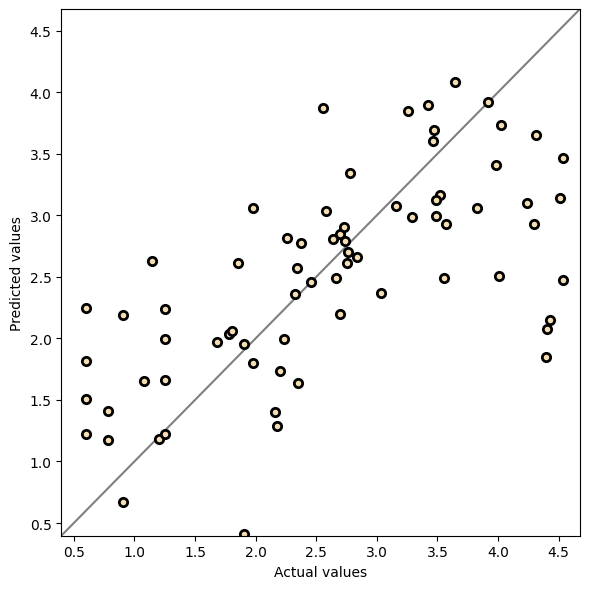

In [24]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_mtser, preds)

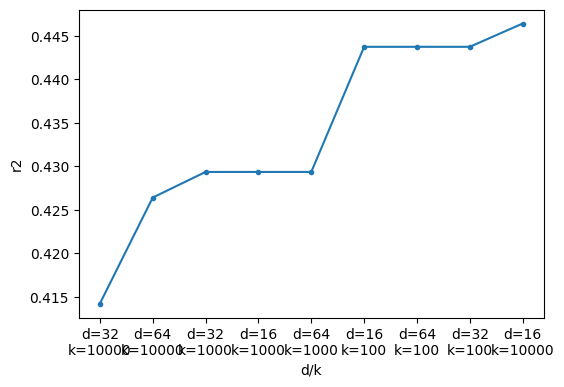

In [ ]:
# FineTuning parameters 

from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from aeon.regression.convolution_based import MiniRocketRegressor

# ==============================================================================
# == fit =======================================================================
# ==============================================================================

param_grid = {
    "n_kernels" : [100, 1000, 10000],
    "max_dilations_per_kernel" : [16, 32, 64],
}

gs = GridSearchCV(
    MiniRocketRegressor(n_jobs=-1, random_state=42),
    param_grid,
)
gs.fit(X_train_mtser, y_train_mtser)

# ==============================================================================
# == plot results ==============================================================
# ==============================================================================

_scores = gs.cv_results_["mean_test_score"]
_params = np.array([f"d={_[0]}\nk={_[1]}" for _ in [tuple(_.values()) for _ in gs.cv_results_["params"]]])
_order = _scores.argsort()
_, a = plt.subplots(1, 1, figsize = (6, 4))
a.plot(_params[_order], _scores[_order], ".-")
a.set(xlabel = "d/k", ylabel = "r2")
plt.show()

In [26]:
# считаем скор для лучшей конфигурации
gs.score(X_test_mtser, y_test_mtser)

0.39129226372986503

In [28]:
# смотри лучший набор

gs

,estimator,MiniRocketReg...ndom_state=42)
,param_grid,"{'max_dilations_per_kernel': [16, 32, ...], 'n_kernels': [100, 1000, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_kernels,10000


# Feature based classification and regression <a id='feature'></a>

Классификаторы и регрессоры на основе признаков являются популярной темой в классификации временных рядов (TSC) и регрессии (TSER).  В пригципе все такие модели представляют собой пайплайны из вытаскивателей фич и классификаторов/регрессоров.

<img src="data/aeon/pipeline.png" alt="Pipeline classifier."><img>

(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

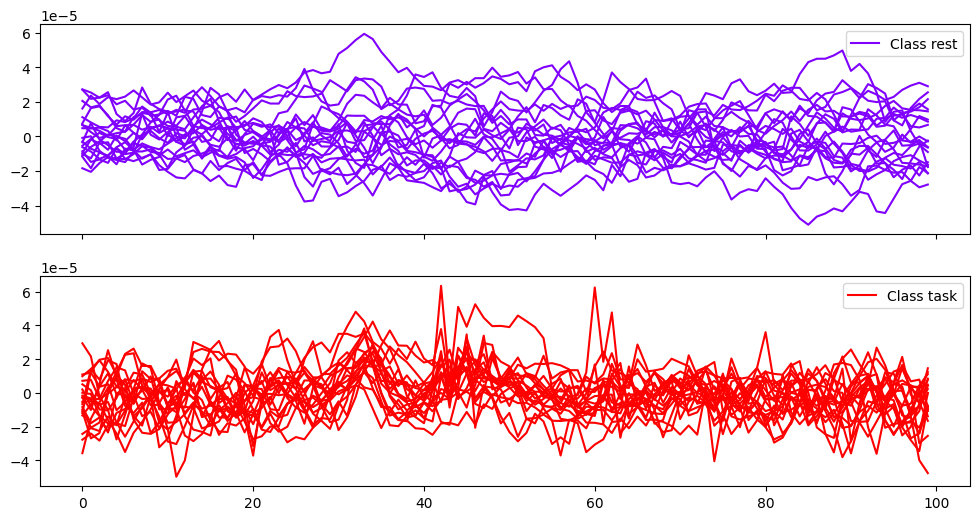

In [36]:
# отрисуем наши данные 

from aeon.visualisation import plot_collection_by_class

plot_collection_by_class(X_train_mtsc[:,2,:], y_train_mtsc)

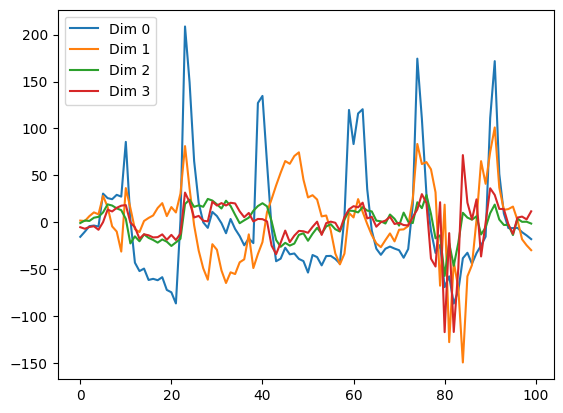

In [37]:
from matplotlib import pyplot as plt

plt.plot(X_train_mtser[0].T)
plt.legend(["Dim 0", "Dim 1", "Dim 2", "Dim 3"])

## Catch22 <a id='catch22'></a>

Набор инструментов для сравнительного анализа временных рядов (hctsa) может создать более 7700 функций для исследовательского анализа временных рядов. К сожалению, в настоящее время в Python не существует полного набора этих функций, заинтересованные пользователи могут ознакомиться с соответствующей публикацией и исходным набором инструментов MATLAB. 

Канонические характеристики временных рядов (Catch22) представляют собой 22 характеристики hctsa, которые считаются наиболее дискриминационными из полного набора.

Функции Catch22 были выбраны путем оценки наборов данных UCR. Характеристики hctsa изначально были сокращены: были удалены те, которые чувствительны к среднему значению и дисперсии, а также те, которые невозможно вычислить для более чем 80 % наборов данных UCR. Затем была проведена оценка функций на основе прогнозируемой производительности. Любые функции, производительность которых была ниже порогового значения, были удалены. Для остальных признаков была выполнена иерархическая кластеризация корреляционной матрицы для устранения избыточности. Из каждого из 22 сформированных кластеров был выбран один признак с учетом сбалансированной точности, вычислительной эффективности и интерпретируемости. Функции Catch22 охватывают широкий спектр понятий, таких как базовая статистика значений рядов данных, линейные корреляции и энтропия.


<img src="data/aeon/catch22.png" alt="Catch22 extraction process."></img>
 

Класс Catch22 преобразует временные ряды в 22 признака.

In [38]:
from aeon.transformations.collection.feature_based import Catch22


c22 = Catch22()
c22.fit_transform(X_train_mtsc)[:5]

array([[-4.94433107e-06,  6.92507633e-06,  2.98422388e+00,
         4.00000000e+00, -8.88178420e-16, -1.01000518e-15,
         0.00000000e+00,  1.60000000e+01,  1.11111111e-01,
         0.00000000e+00,  0.00000000e+00,  3.00000000e+00,
         3.84615385e-02, -2.70000000e-01,  5.30000000e-01,
         1.57359203e-10,  5.00000000e+00,  2.00785293e+00,
         8.28571429e-01,  6.00000000e-01,  4.90873852e-01,
         1.40193684e-05,  1.81815758e-06, -1.47671393e-06,
         3.71562980e+00,  4.00000000e+00, -8.88178420e-16,
        -5.87837340e-16,  0.00000000e+00,  1.70000000e+01,
         6.25000000e-02,  0.00000000e+00,  0.00000000e+00,
         3.00000000e+00,  4.54545455e-02, -2.30000000e-01,
         4.90000000e-01,  7.77998115e-11,  7.00000000e+00,
         2.00199666e+00,  8.28571429e-01,  8.28571429e-01,
         2.94524311e-01,  1.02667064e-05, -6.81925616e-06,
        -2.74171769e-06,  2.54465362e+00,  5.00000000e+00,
        -8.88178420e-16, -4.07928862e-16,  0.00000000e+0

In [40]:
from aeon.transformations.collection.feature_based._catch22 import feature_names

feature_names

['DN_HistogramMode_5',
 'DN_HistogramMode_10',
 'CO_f1ecac',
 'CO_FirstMin_ac',
 'CO_HistogramAMI_even_2_5',
 'CO_trev_1_num',
 'MD_hrv_classic_pnn40',
 'SB_BinaryStats_mean_longstretch1',
 'SB_TransitionMatrix_3ac_sumdiagcov',
 'PD_PeriodicityWang_th0_01',
 'CO_Embed2_Dist_tau_d_expfit_meandiff',
 'IN_AutoMutualInfoStats_40_gaussian_fmmi',
 'FC_LocalSimple_mean1_tauresrat',
 'DN_OutlierInclude_p_001_mdrmd',
 'DN_OutlierInclude_n_001_mdrmd',
 'SP_Summaries_welch_rect_area_5_1',
 'SB_BinaryStats_diff_longstretch0',
 'SB_MotifThree_quantile_hh',
 'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
 'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
 'SP_Summaries_welch_rect_centroid',
 'FC_LocalSimple_mean3_stderr']

Преобразование можно настроить, и вы можете выбрать подмножество функций для извлечения. Параметр catch24 будет включать среднее и стандартное отклонение, а также исходные 22 функции. 

pycatch22 будет использовать библиотеку pycatch22, завернутую в C.

In [41]:
c22 = Catch22(
    features=["DN_HistogramMode_5", "CO_f1ecac", "SB_MotifThree_quantile_hh", "Mean", "StandardDeviation"],
    catch24=True,
)
c22.fit_transform(X_train_mtsc)[:5]

array([[-4.94433107e-06,  2.98422388e+00,  2.00785293e+00,
        -4.84662295e-06,  1.63624369e-05,  1.81815758e-06,
         3.71562980e+00,  2.00199666e+00,  4.07268745e-07,
         1.16629572e-05, -6.81925616e-06,  2.54465362e+00,
         1.84997494e+00, -2.73869572e-06,  1.30628441e-05,
        -4.28629432e-06,  2.25468230e+00,  1.94369228e+00,
        -3.51260400e-06,  8.11090668e-06],
       [-4.93347026e-07,  9.76550866e-01,  2.08655852e+00,
         1.43118551e-06,  1.57514418e-05,  1.06128379e-06,
         2.99539703e+00,  2.05946536e+00,  4.93131265e-06,
         1.18989896e-05, -9.48719145e-06,  1.78980033e+00,
         1.96831980e+00, -3.01206374e-06,  1.42330289e-05,
        -2.88989693e-06,  2.21747187e+00,  2.04733206e+00,
        -2.96546855e-06,  8.23176010e-06],
       [-6.72778723e-06,  8.30813700e-01,  2.17460531e+00,
        -6.06350354e-07,  1.33059491e-05, -1.44995057e-06,
         7.17005807e-01,  2.16552480e+00,  3.79695308e-06,
         1.00766877e-05, -1.8

Классы Catch22Classifier и Catch22Regressor в aeon — это просто удобные оболочки для конвейера преобразования Catch22 и случайного леса, обучаемого scikit-learn по умолчанию.

In [42]:
from aeon.classification.feature_based import Catch22Classifier
from sklearn.metrics import accuracy_score

c22_cls = Catch22Classifier(random_state=42)
c22_cls.fit(X_train_mtsc, y_train_mtsc)
c22_preds_c = c22_cls.predict(X_test_mtsc)
accuracy_score(y_test_mtsc, c22_preds_c)

0.9

In [43]:
from aeon.classification.sklearn import RotationForestClassifier

c22_cls = Catch22Classifier(
    features=["DN_HistogramMode_5", "CO_f1ecac", "SB_MotifThree_quantile_hh", "Mean", "StandardDeviation"],
    estimator=RotationForestClassifier(),
    random_state=42,
)
c22_cls.fit(X_train_mtsc, y_train_mtsc)
c22_preds_c = c22_cls.predict(X_test_mtsc)
accuracy_score(y_test_mtsc, c22_preds_c)

0.9

In [44]:
from aeon.regression.feature_based import Catch22Regressor
from sklearn.metrics import mean_squared_error

c22_reg = Catch22Regressor(random_state=42)
c22_reg.fit(X_train_mtser, y_train_mtser)
c22_preds_r = c22_reg.predict(X_test_mtser)
mean_squared_error(y_test_mtser, c22_preds_r)

0.7975235446926242

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

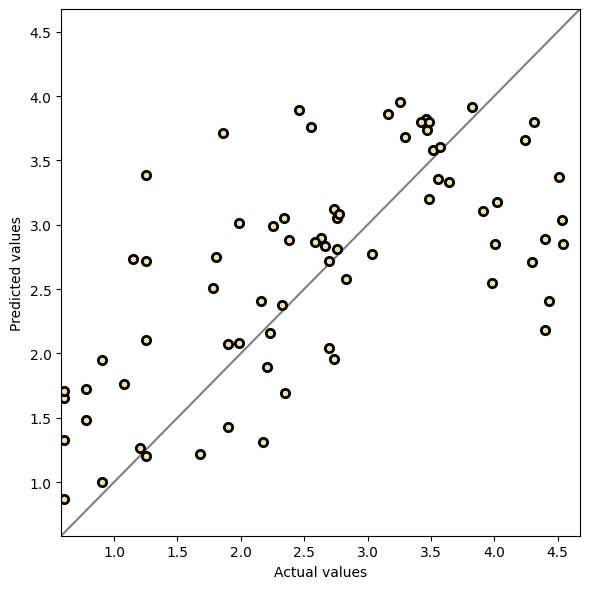

In [45]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_mtser, c22_preds_r)

# Deep Leaning подходы <a id='deep'></a>

Можно сказать, что на данном этапе модели глубокого обучения являются SOTA моделями для решения задач классификации и регрессии временных рядов. 


<img src="data/aeon/deep-legend.png" alt="Deep Legend."></img>

In [49]:
# Для классификации
# нормализуем по среднему и дисперсии наши ряды 
X_train_c = (X_train_mtsc - X_train_mtsc.mean(axis=-1, keepdims=True)) / (X_train_mtsc.std(axis=-1, keepdims=True))
X_test_c = (X_test_mtsc - X_test_mtsc.mean(axis=-1, keepdims=True)) / (X_test_mtsc.std(axis=-1, keepdims=True))

print("Train shape:", X_train_c.shape)
print("Test shape:", X_test_c.shape)

Train shape: (40, 4, 100)
Test shape: (40, 4, 100)


(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

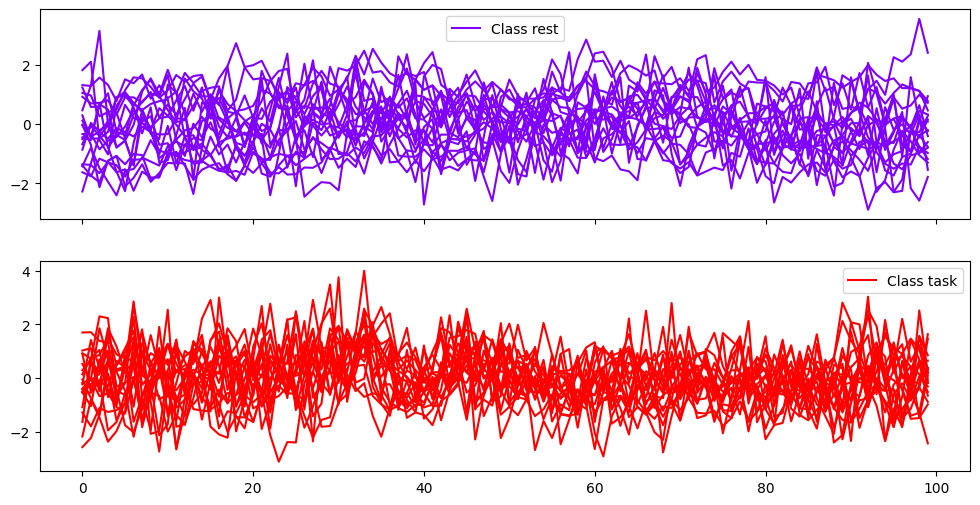

In [48]:
from aeon.visualisation import plot_collection_by_class

plot_collection_by_class(X_train_c[:,0,:], y_train_mtsc)

In [50]:
# для регрессии

# znormalize the series
X_train_r = (X_train_mtser - X_train_mtser.mean(axis=-1, keepdims=True)) / (X_train_mtser.std(axis=-1, keepdims=True))
X_test_r = (X_test_mtser - X_test_mtser.mean(axis=-1, keepdims=True)) / (X_test_mtser.std(axis=-1, keepdims=True))

print("Train shape:", X_train_mtser.shape)
print("Test shape:", X_test_mtser.shape)

Train shape: (72, 4, 100)
Test shape: (72, 4, 100)


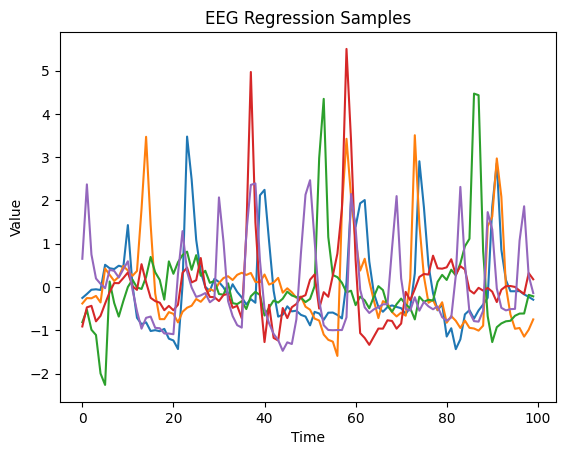

In [51]:
from matplotlib import pyplot as plt

plt.plot(X_train_r[:5,0,:].T)
plt.title("EEG Regression Samples")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

## Multi Layer Perceptron (MLP)


Многослойный персептрон (MLP), простейшая модель нейронных сетей, часто используется в качестве основы для моделей глубокого обучения. Однако применительно к данным временных рядов он не учитывает временные зависимости. Модель MLP пытается найти оптимальную нелинейную комбинацию входных функций для достижения хорошей производительности последующей задачи.

<img src="data/aeon/MLP.png" alt="mlp"><i>

In [53]:
from aeon.classification.deep_learning import MLPClassifier
from sklearn.metrics import accuracy_score

mlp_cls = MLPClassifier(n_epochs=100)
mlp_cls.fit(X_train_c, y_train_mtsc)
mlp_cls_preds = mlp_cls.predict(X_test_c)
print(accuracy_score(y_test_mtsc, mlp_cls_preds))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
0.6


In [54]:
from aeon.regression.deep_learning import MLPRegressor
from sklearn.metrics import mean_squared_error

mlp_rgs = MLPRegressor(n_epochs=500)
mlp_rgs.fit(X_train_r, y_train_mtser)
mlp_rgs_preds = mlp_rgs.predict(X_test_r)
print(mean_squared_error(y_test_mtser, mlp_rgs_preds))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1.6171353181226782


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'MLP Predictions'}, xlabel='Actual values', ylabel='Predicted values'>)

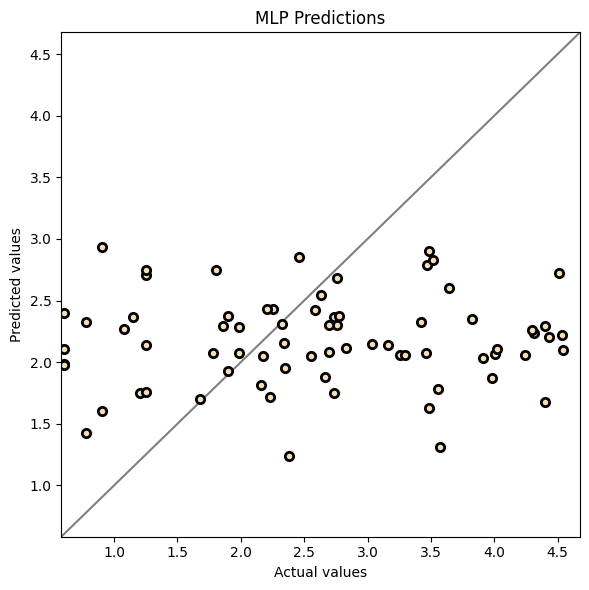

In [55]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_mtser, mlp_rgs_preds, title="MLP Predictions")

## The Fully Convolutional Neural Network (FCNRegressor)


Полностью сверточные нейронные сети (FCN) все чаще используются для анализа временных рядов благодаря их способности эффективно улавливать локальные закономерности и многомасштабные зависимости.

Сверточная нейронная сеть по времени (TimeCNN) — это сверточная нейронная сеть, в которой процесс оптимизации фокусируется на изучении наиболее эффективных фильтров для достижения оптимальных результатов. В отличие от MLP, TimeCNN использует локальные свертки, позволяя улавливать и учитывать временные зависимости в данных, что делает их более подходящими для анализа временных рядов.

<img src="data/aeon/TimeCNN.png" alt="cnn"><i>

In [65]:
from aeon.classification.deep_learning import FCNClassifier
from sklearn.metrics import accuracy_score

# n_epochs chooses the number of training iterations
# verbose show the network's detail and the logs of training
cnn_cls = FCNClassifier(n_epochs=500, verbose=True, save_best_model=True, best_file_name="best_cnn")
cnn_cls.fit(X_train_c, y_train_mtsc)
cnn_cls_preds = cnn_cls.predict(X_test_c)
print(accuracy_score(y_test_mtsc, cnn_cls_preds))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 128)       │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 100, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,058 (1.03 MB)

 Trainable params: 268,034 (1.02 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6250 - loss: 0.5994 - learning_rate: 0.0010
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9250 - loss: 0.2128 - learning_rate: 0.0010
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9750 - loss: 0.1078 - learning_rate: 0.0010
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0590 - learning_rate: 0.0010
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0378 - learning_rate: 0.0010
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0264 - learning_rate: 0.0010
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0200 - learning_rate: 0.0010
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.0159 - learning_rate: 0.0010
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0130 - learning_rate: 0.0010
Epoch 10/500
3/3 ━━━━━━━━━━━

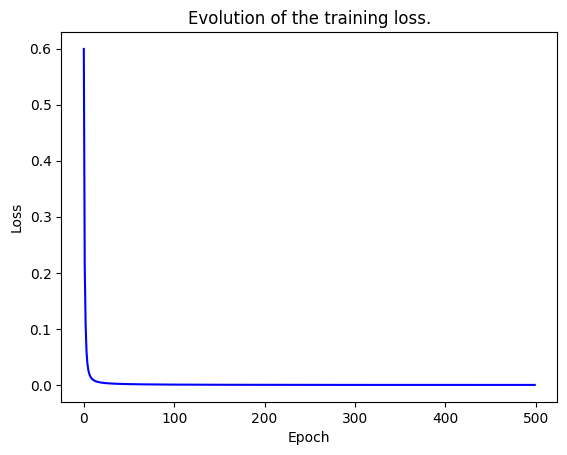

In [66]:
import matplotlib.pyplot as plt

# you can retrieve the history of training to visualize the loss
loss = cnn_cls.history.history["loss"]
plt.plot(loss, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of the training loss.")
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

cnn_best = tf.keras.models.load_model("best_cnn.keras", compile=False)

[<InputLayer name=input_layer_3, built=True>,
 <Conv1D name=conv1d_3, built=True>,
 <BatchNormalization name=batch_normalization_3, built=True>,
 <Activation name=activation_3, built=True>,
 <Conv1D name=conv1d_4, built=True>,
 <BatchNormalization name=batch_normalization_4, built=True>,
 <Activation name=activation_4, built=True>,
 <Conv1D name=conv1d_5, built=True>,
 <BatchNormalization name=batch_normalization_5, built=True>,
 <Activation name=activation_5, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d_1, built=True>,
 <Dense name=dense_9, built=True>]

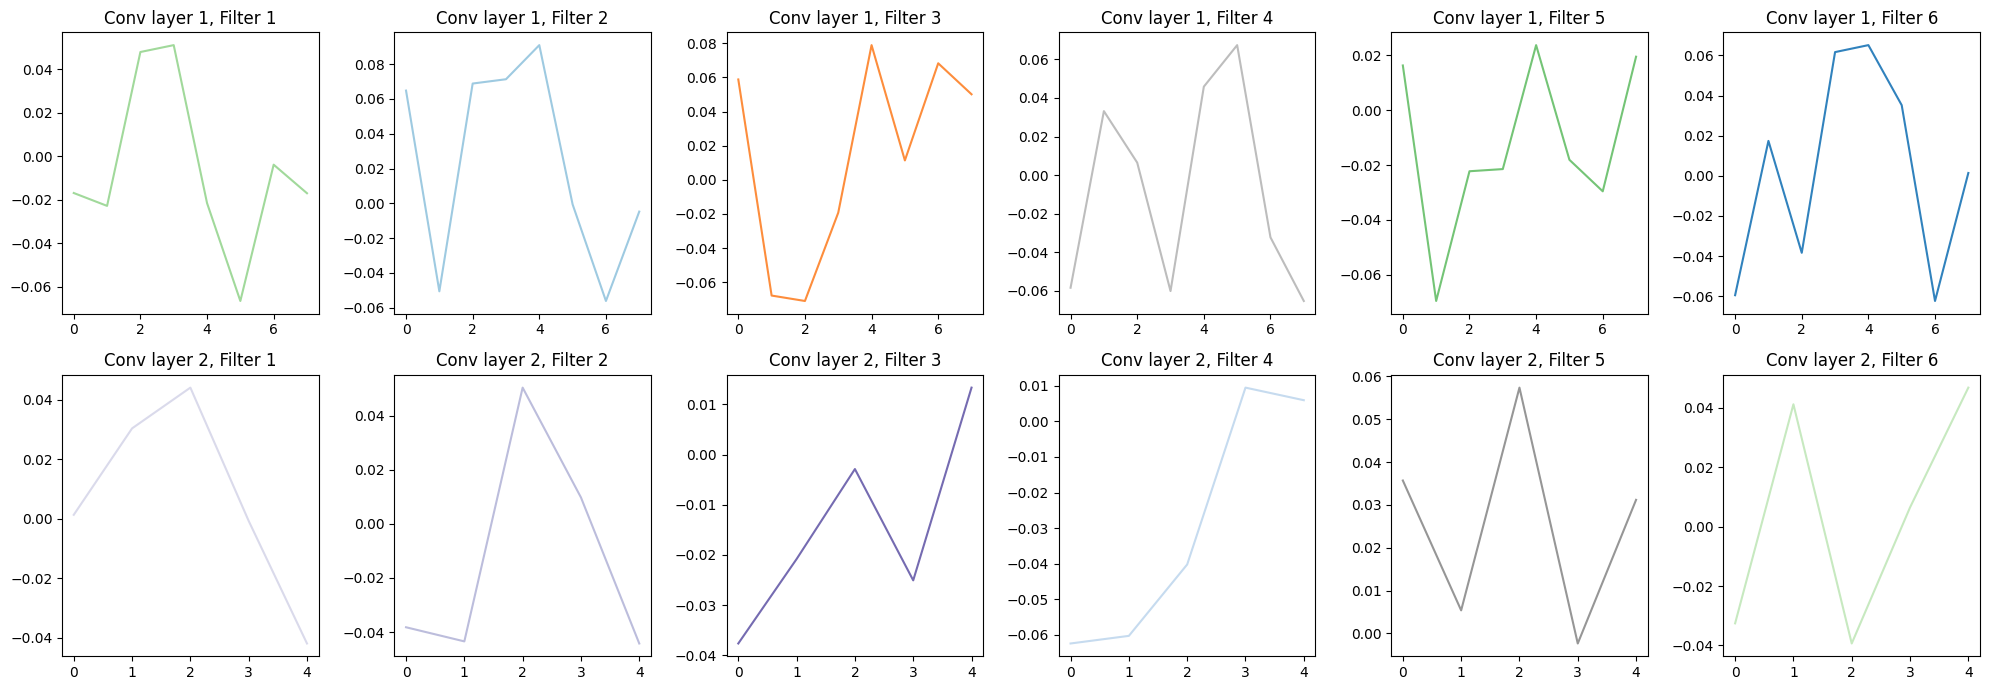

In [ ]:
#get conv weights of layer 1  
conv1_weights = cnn_best.layers[1].get_weights()[0]

#get conv weights of layer 2  
conv2_weights = cnn_best.layers[4].get_weights()[0]

fig,ax = plt.subplots(2,6,figsize=(20,7))

cmap = plt.get_cmap('tab20c')
values = np.linspace(0, 1, 18)
np.random.shuffle(values)

for i in range(6):
  ax[0,i].plot(conv1_weights[:,0,i],color=cmap(values[i]))
  ax[0,i].set_title('Conv layer 1, Filter ' + str(i+1))
  ax[1,i].plot(conv2_weights[:,0,i],color=cmap(values[6+i]))
  ax[1,i].set_title('Conv layer 2, Filter ' + str(i+1))
plt.tight_layout()
plt.show()

#os.remove("best_cnn.keras")

In [73]:
from aeon.regression.deep_learning import FCNRegressor
from sklearn.metrics import mean_squared_error

cnn_rgs = FCNRegressor(n_epochs=500)
cnn_rgs.fit(X_train_r, y_train_mtser)
cnn_rgs_preds = cnn_rgs.predict(X_test_r)
print(mean_squared_error(y_test_mtser, cnn_rgs_preds))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
1.2391741678125805


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'FCNRegressor Predictions'}, xlabel='Actual values', ylabel='Predicted values'>)

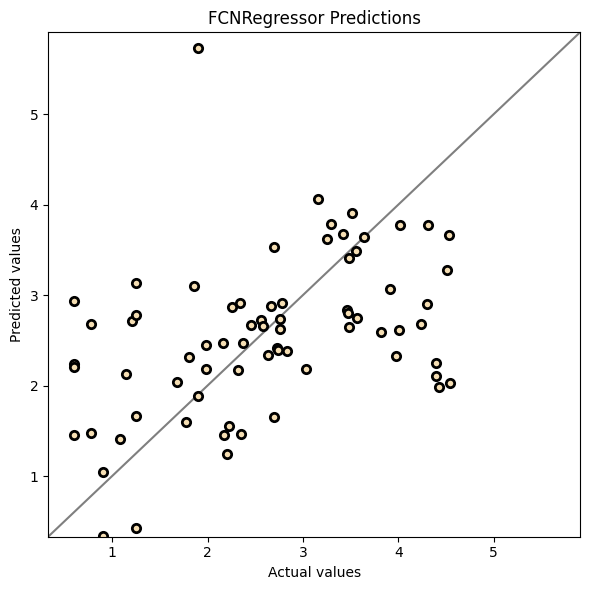

In [74]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_mtser, cnn_rgs_preds, title="FCNRegressor Predictions")

In [75]:
from aeon.classification.deep_learning import  TimeCNNClassifier
from sklearn.metrics import accuracy_score

# n_epochs chooses the number of training iterations
# verbose show the network's detail and the logs of training
cnn_cls = TimeCNNClassifier(n_epochs=500, verbose=True, save_best_model=True, best_file_name="best_time_cnn")
cnn_cls.fit(X_train_c, y_train_mtsc)
cnn_cls_preds = cnn_cls.predict(X_test_c)
print(accuracy_score(y_test_mtsc, cnn_cls_preds))

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 94, 6)          │           174 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 31, 6)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 25, 12)         │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 8, 12)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 884 (3.45 KB)

 Trainable params: 884 (3.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5000 - loss: 0.2771 
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5000 - loss: 0.2653
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.2569
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.2513
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.2484
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6500 - loss: 0.2476
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.2480
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5000 - loss: 0.2491
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5000 - loss: 0.2503
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5000 - loss: 0.2513
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5000 - loss: 0.2518
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5000 - l

In [76]:
cnn_t_best = tf.keras.models.load_model("best_time_cnn.keras", compile=False)
cnn_t_best.layers 

[<InputLayer name=input_layer_5, built=True>,
 <Conv1D name=conv1d_9, built=True>,
 <AveragePooling1D name=average_pooling1d, built=True>,
 <Conv1D name=conv1d_10, built=True>,
 <AveragePooling1D name=average_pooling1d_1, built=True>,
 <Flatten name=flatten_2, built=True>,
 <Dense name=dense_11, built=True>]

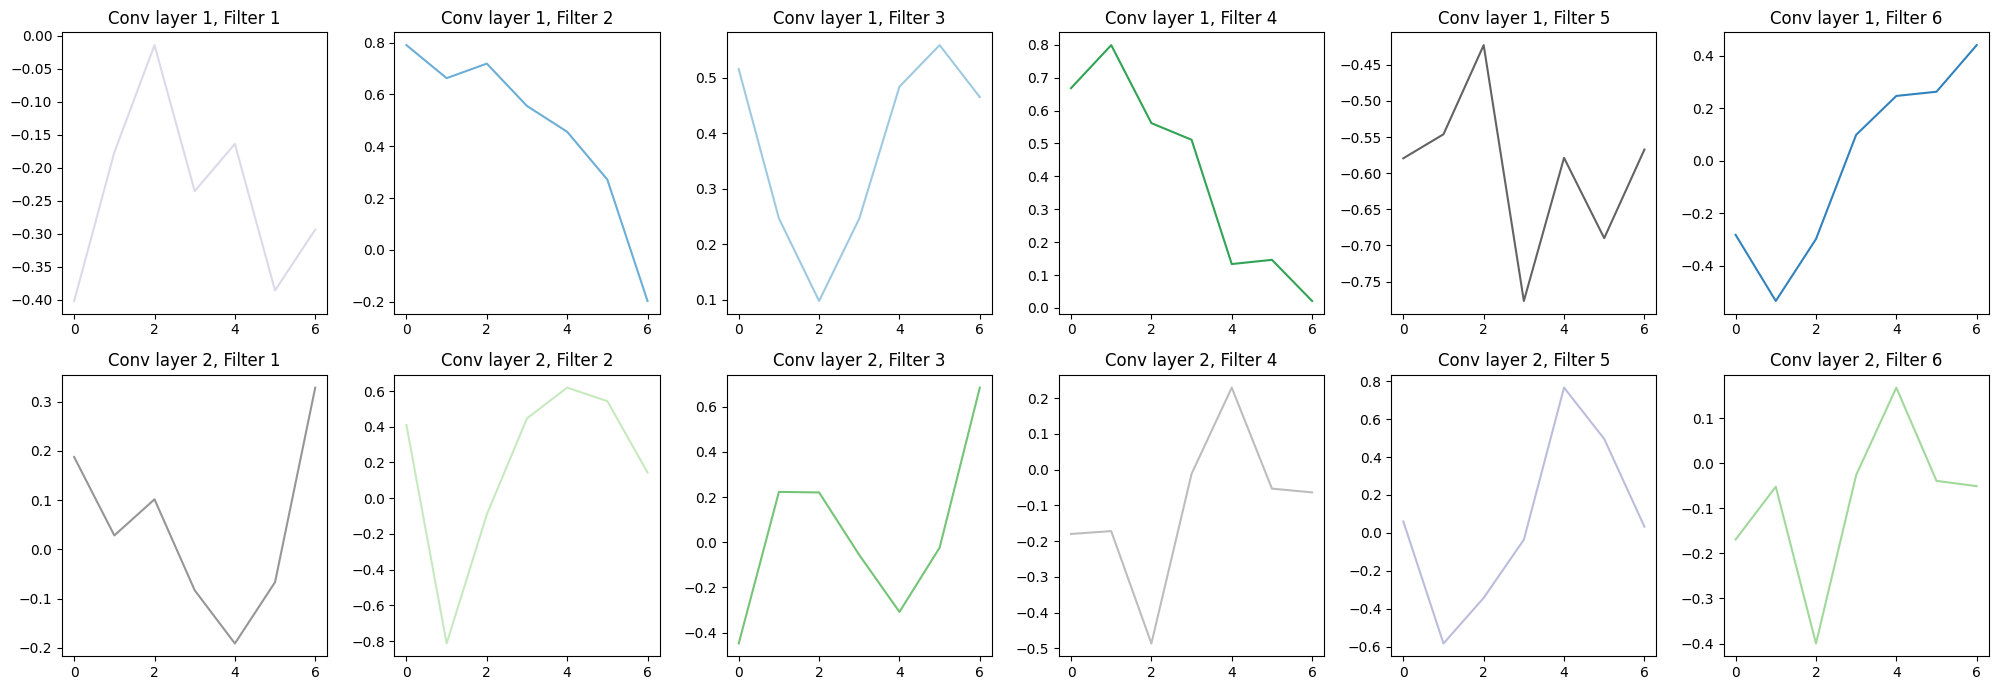

In [77]:
#get conv weights of layer 1  
conv1_weights = cnn_t_best.layers[1].get_weights()[0]

#get conv weights of layer 2  
conv2_weights = cnn_t_best.layers[3].get_weights()[0]

fig,ax = plt.subplots(2,6,figsize=(20,7))

cmap = plt.get_cmap('tab20c')
values = np.linspace(0, 1, 18)
np.random.shuffle(values)

for i in range(6):
  ax[0,i].plot(conv1_weights[:,0,i],color=cmap(values[i]))
  ax[0,i].set_title('Conv layer 1, Filter ' + str(i+1))
  ax[1,i].plot(conv2_weights[:,0,i],color=cmap(values[6+i]))
  ax[1,i].set_title('Conv layer 2, Filter ' + str(i+1))
plt.tight_layout()
plt.show()

#os.remove("best_cnn.keras")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1.485700454367964


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'TimeCNNRegressor Predictions'}, xlabel='Actual values', ylabel='Predicted values'>)

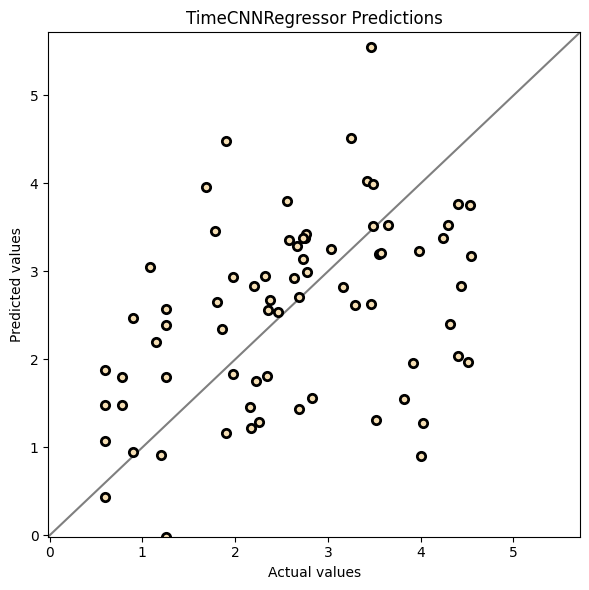

In [79]:
from aeon.regression.deep_learning import  TimeCNNRegressor
from sklearn.metrics import mean_squared_error

cnn_rgs = TimeCNNRegressor(n_epochs=500)
cnn_rgs.fit(X_train_r, y_train_mtser)
cnn_rgs_preds = cnn_rgs.predict(X_test_r)
print(mean_squared_error(y_test_mtser, cnn_rgs_preds))

plot_scatter_predictions(y_test_mtser, cnn_rgs_preds, title="TimeCNNRegressor Predictions")

# Упражнения <a id='tasks'></a>

1. Взять выбранные для лабы 9 набор(ы) данных. Можно взять разные наборы для классификации/регрессии (но причину надо будет обосновать)

2. Отрисовать данные

3. Попробовать все методы классификации и регрессии, описанные в блоноте:
    Distance-based 
    Свертки (модели семейства Rocket и Hydra)
    Feature-based
    Deep Learning

    Для каждого подхода обучть не менее 3х разных моделей для классификации и регрессии.
    
     
    